In the previous notebook, Tim gave a fantastic example of working with a dataset and pipelining analysis given a dataset. One thing that was not mentioned is the ability for additional variables not explicitly in the original dataset to be calculated that can further enhance signal. 

In [1]:
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

#raw_trees=pd.read_csv("FinalOverObTableWAR.csv")

#Now that we have a data dictionary, we can get rid of many of the irrelevant columns. I selected this particular subset also using some forestry knowledge (doubtful of the various volume variables contribution to crown class)
fields = ['CLUSTER','ID',
'tree_obs_id','tree_spp',
'tree_dbh','tree_stems',
'tree_height','tree_crown_class',
'tree_stems_per','tree_ba',
'stand_id','OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id'
]

#Create a dataframe from just the subset of cols using same dataset from original notebook.
reduced_data = pd.read_csv("FinalOverObTableWAR.csv", usecols = fields)

We know that tree height is collected in 5 ft bins, which limits the resolution and categorical variables can be tricky. 
One way to convert it would be to add some random noise between (0,1) to each height bin that it falls in. 
This won't change the bin and it won't change the relation between trees.

In [6]:
reduced_data['tree_height_cont'] = reduced_data['tree_height'] + [random.random() for _ in range(0, len(reduced_data))]

reduced_data[['tree_height','tree_height_cont']].head(10)


,tree_height,tree_height_cont
0,65,65.182456
1,55,55.294726
2,50,50.282759
3,40,40.647076
4,65,65.622253
5,70,70.805170
6,65,65.332945
7,65,65.906903
8,65,65.883154
9,55,55.017165


Knowing what we know about crown class, we can think about how the height of a given tree is perhaps less important than it's height relative to it's peers. A 30' tall tree may be impressive in a seed tree cut, but less so in a mature stand. One way to codify this is to look at height percentiles and where a tree falls.

Height can be informative, but basal area is also very strongly of a individual's competitive status. We will also calculate the basal area percentile.

In [3]:
reduced_data['ht_percentile_stand'] = reduced_data.groupby('stand_id')['tree_height_cont'].rank(pct=True)
reduced_data['BA_percentile_stand'] = reduced_data.groupby('stand_id')['tree_ba'].rank(pct=True)

reduced_data['ht_percentile_plot'] = reduced_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_height_cont'].rank(pct=True)
reduced_data['BA_percentile_plot'] = reduced_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_ba'].rank(pct=True)

reduced_data['ht_percentile_ratio'] = reduced_data['ht_percentile_plot'] / reduced_data['ht_percentile_stand'] 
reduced_data['BA_percentile_ratio'] = reduced_data['BA_percentile_plot'] / reduced_data['BA_percentile_stand']




In [ ]:
#Still need to figure out BAL function...

#MWE
import pandas as pd
import numpy as np

df = pd.DataFrame({'Grp': [1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4], 
                   'Obs': [1,4,7,3,2,5,2,5,7,7,4,2,9,10,12,9,5,3,2,4,11,7,4,8,3],
                   'expected_output' : [28,17,0,21,26,12,26,12,38,38,45,49,22,12,0,0,9,18,21,14,0,19,26,11,30]})




Now that we have calculated everything, let's check if they actually are meaningful or if my hunch was incorrect. We can do this by running the subset variables and new calculated variables through a RandomForest and check the variable importance.

In [4]:
#random forest 


#we need to re-encode categorical variables
reduced_data['tree_spp2']=pd.factorize(reduced_data['tree_spp'])[0]
reduced_data['tree_obs_id2']=pd.factorize(reduced_data['tree_obs_id'])[0]

#predictors
features = ['tree_obs_id2','tree_spp2',
'tree_dbh','tree_stems',
'tree_height','tree_stems_per','tree_ba',
'tree_height_cont',
'ht_percentile_stand',
'BA_percentile_stand',
'ht_percentile_plot',
'BA_percentile_plot',
'ht_percentile_ratio',
'BA_percentile_ratio']

#response variable
train = ['tree_crown_class']

rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)

rnd_clf.fit(reduced_data[features], reduced_data["tree_crown_class"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

With the model fit, we have to do some more work to get a variable importance plot

tree_obs_id2 = 0.0653528394804471
tree_spp2 = 0.03135498567126365
tree_dbh = 0.04248497484923248
tree_stems = 1.6034299456525964e-06
tree_height = 0.03516882767655343
tree_stems_per = 0.031028925682762994
tree_ba = 0.04058352914776957
tree_height_cont = 0.11005400349087797
ht_percentile_stand = 0.10600657783914079
BA_percentile_stand = 0.08182065782334848
ht_percentile_plot = 0.12908322230054592
BA_percentile_plot = 0.1323171395067252
ht_percentile_ratio = 0.10225359223956144
BA_percentile_ratio = 0.09248912086182555


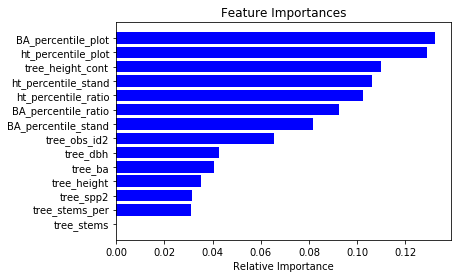

In [7]:
for name, importance in zip(reduced_data[features], rnd_clf.feature_importances_):
    print(name, "=", importance)

import numpy as np
feat = reduced_data[features]
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)



plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feat.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

So we can see that all of the calculated variables are at the top of the importance graph so we have been successful in creating meaningful features.